In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
%matplotlib inline

# Reading and Cleaning

In [2]:
data = pd.read_csv('winemag-data_first150k.csv')
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Lots of duplicates
There are a lot of duplicates in this data. Oddly enough, I noticed that simply running data.drop_duplicates() did not remove all duplicates, which is the result of some columns between the duplicated rows differeing. Nevertheless, the fact that the "Description" columns were identical was a dead giveaway that these were not a different reviews. 

In [3]:
data[data.duplicated('description',keep=False)].sort_values('description').head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
62345,62345,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
74993,74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
18803,18803,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
26530,26530,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister


I decided to drop all duplicates based on the description column alone and subsequently all missing price data:

In [4]:
data = data.drop_duplicates('description')
data = data[pd.notnull(data.price)]
data.shape

(89108, 11)

# Exploratory Analysis
Not surprisingly, there's a significant correlation between the cost of wine and its rating, namely theres an average $1.18  increase for every one point incrase in rating.

Pearson Correlation: (0.44728139684845519, 0.0)
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                 7.585e+04
Date:                Wed, 19 Jul 2017   Prob (F-statistic):               0.00
Time:                        01:05:46   Log-Likelihood:            -4.9789e+05
No. Observations:               89108   AIC:                         9.958e+05
Df Residuals:                   89107   BIC:                         9.958e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
pric

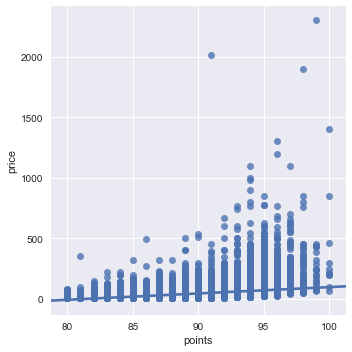

In [5]:
from scipy.stats import pearsonr
import statsmodels.api as sm
print("Pearson Correlation:", pearsonr(data.price, data.points))
print(sm.OLS(data.points, data.price).fit().summary())
sns.lmplot(y = 'price', x='points', data=data)


Plotting all the countries, there's some odd plots as a result of low sample size for certain countries.

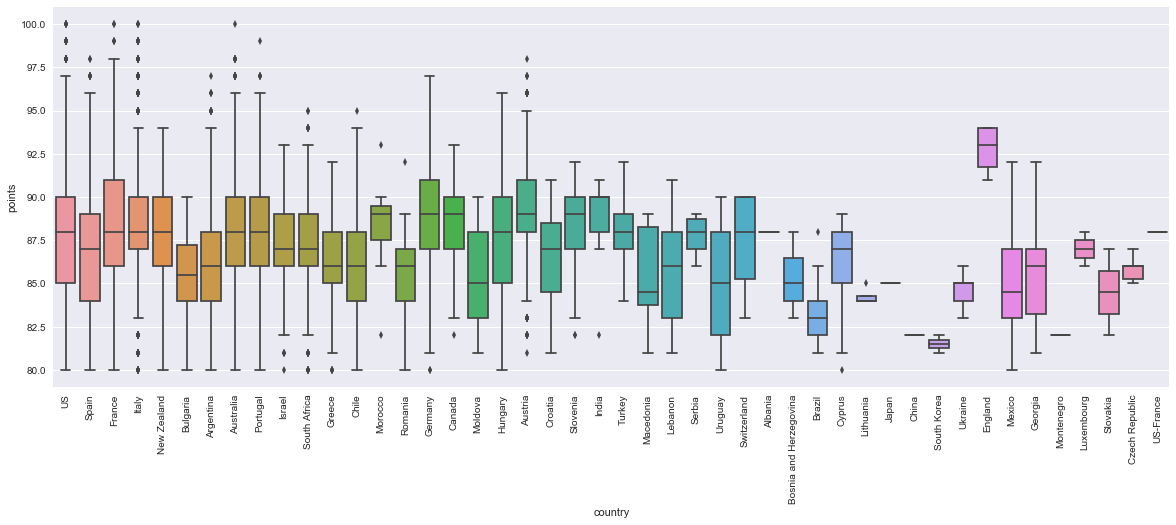

In [6]:
fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=data, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [7]:
data.country.value_counts()[:17]

US              40338
Italy           12152
France          10184
Spain            5370
Chile            3700
Argentina        3419
Australia        3098
Portugal         2726
New Zealand      1744
Austria          1596
Germany          1482
South Africa     1464
Greece            535
Israel            354
Canada            148
Hungary           138
Romania           106
Name: country, dtype: int64

After removing all countries with less than 100 observations, it appears that Germany, Austria, and Canada have the highest median scores(points). However, the distribution overall appears to be fairly uniform.

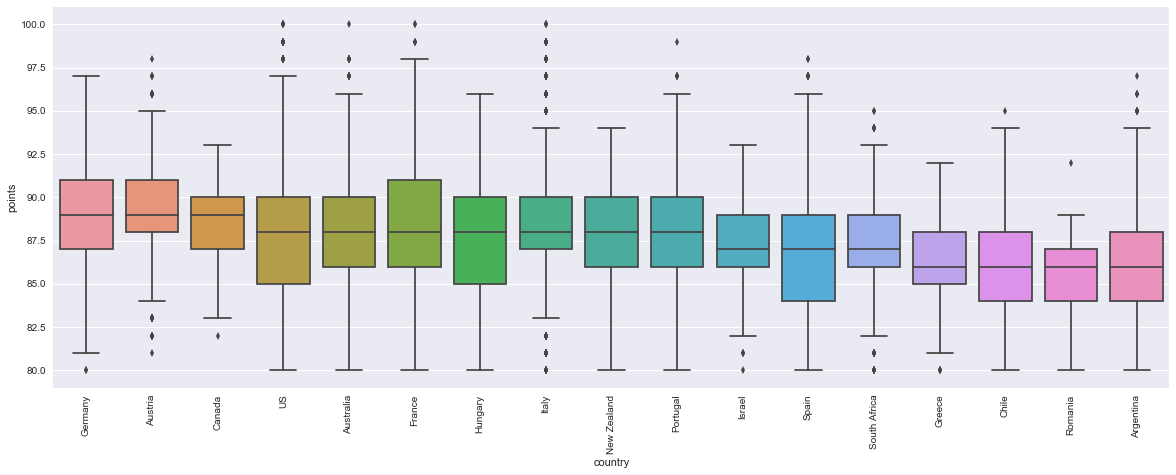

In [8]:
country=data.groupby('country').filter(lambda x: len(x) >100)
df2 = pd.DataFrame({col:vals['points'] for col,vals in country.groupby('country')})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='country',y='points', data=country, order=meds.index, ax = ax)
plt.xticks(rotation = 90)

plt.show()

Below are the average wine prices sorted by median (highest to lowest) in order to evaluate price distortions due to outliers.

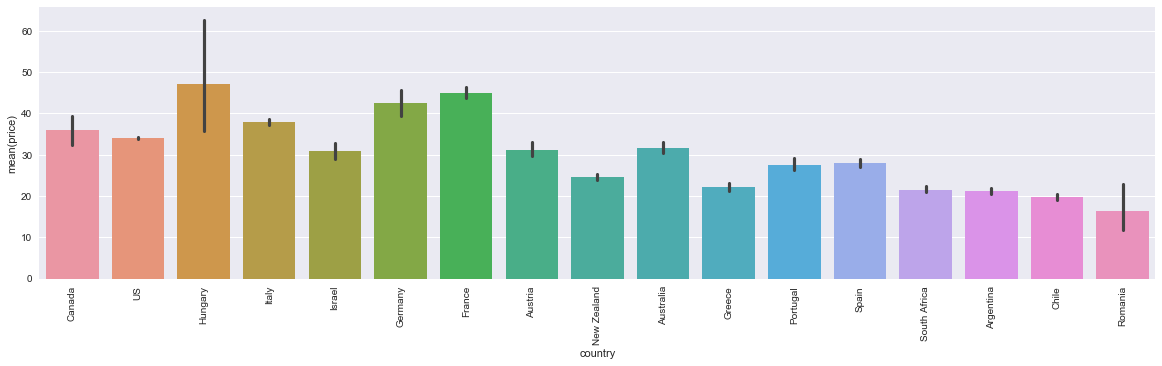

In [9]:
df3 = pd.DataFrame({col:vals['price'] for col,vals in country.groupby('country')})
meds2 = df3.median()
meds2.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize = (20,5))
chart = sns.barplot(x='country',y='price', data=country, order=meds2.index, ax = ax)
plt.xticks(rotation = 90)
plt.show()

In [10]:
# medians for the above barplot
print(meds2)

Canada          30.0
US              28.0
Hungary         27.0
Italy           26.0
Israel          25.0
Germany         25.0
France          25.0
Austria         24.0
New Zealand     20.0
Australia       20.0
Greece          18.0
Portugal        17.0
Spain           17.0
South Africa    17.0
Argentina       15.0
Chile           14.0
Romania         10.0
dtype: float64


There's a large variety of wines in the dataset (I never knew there was so many!) However, there's an exponential decline in the number of observations for each wine type, and since we'll be attempting to use these labels to classify our model, I'll be dropping any wine types with less than 200 observations, for the reason that I don't believe there's enough data in these buckets to generate an accuarte model for predicting their respective wine type

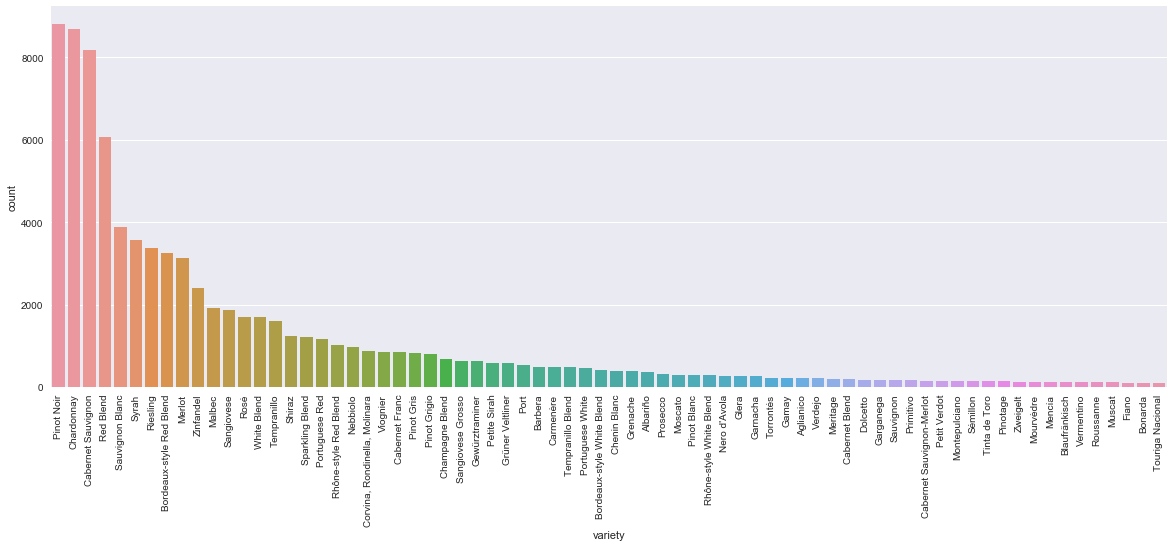

In [11]:
data = data.groupby('variety').filter(lambda x: len(x) >100)
list = data.variety.value_counts().index.tolist()
fig4, ax4 = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax=ax4)
plt.xticks(rotation = 90)
plt.show()

Below is a boxplot chart containing all wine varieties (w/ >200 observations) and their respective point distributions. Sangiovese Grosso (never tried it) appears to have the highest median score of all wines. There are some interesting dips occuring after Champagne Blend, Shiraz, Cabernet Sauvignon (my favorite), and Nero d'Avola. Of interest is Merlot, which tends to have a large number of highly reviewed outliers. Despite these slight variations, overall the point distibution is basically uniform.

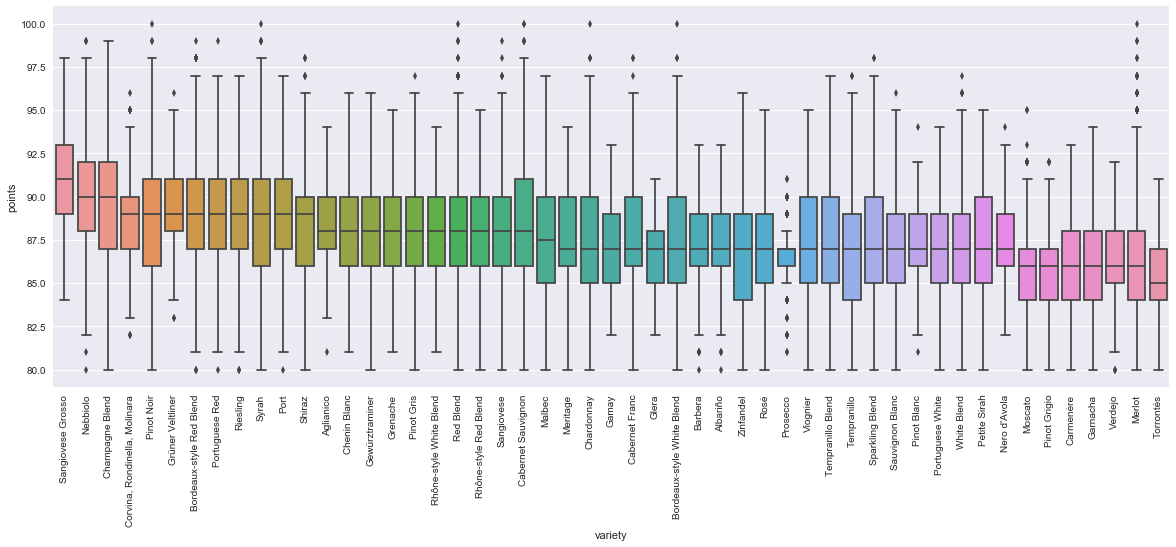

In [12]:
data = data.groupby('variety').filter(lambda x: len(x) >200)

df4 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
meds3 = df4.median()
meds3.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.boxplot(x='variety',y='points', data=data, order=meds3.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

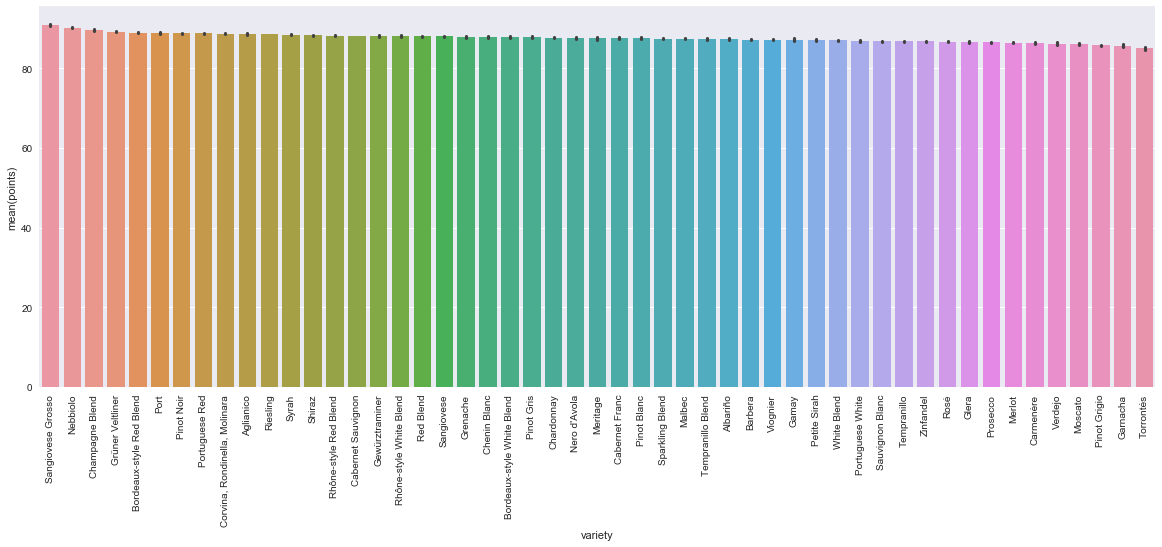

In [13]:
df5 = pd.DataFrame({col:vals['points'] for col,vals in data.groupby('variety')})
mean1 = df5.mean()
mean1.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='points', data=data, order=mean1.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

It's definitely not the same story when you look at price. There's clear variation in here, which may help in predicting the wine type.

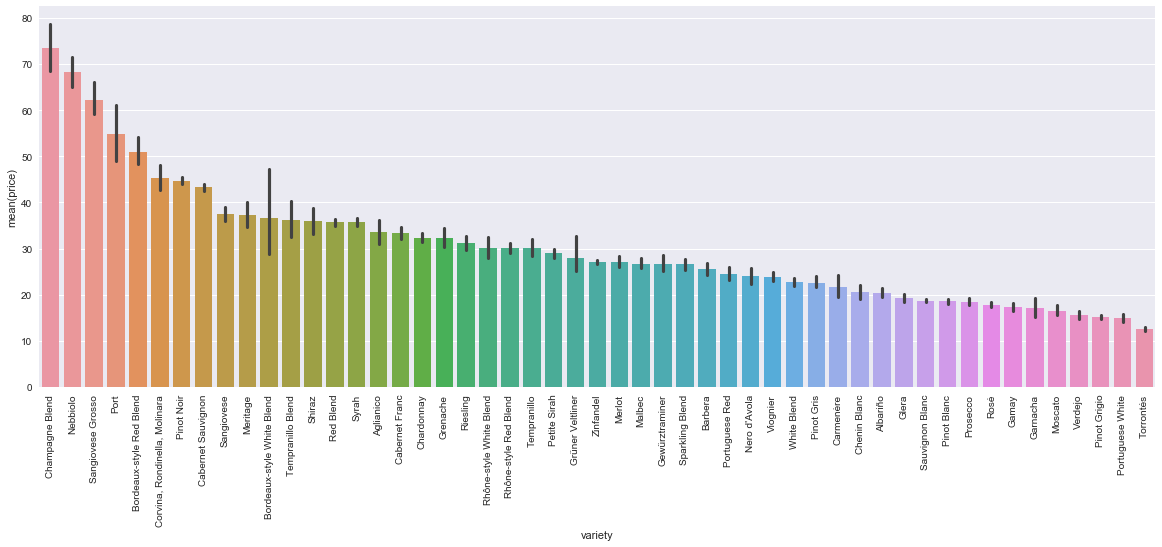

In [14]:
df6 = pd.DataFrame({col:vals['price'] for col,vals in data.groupby('variety')})
mean2 = df6.mean()
mean2.sort_values(ascending=False, inplace=True)

fig3, ax3 = plt.subplots(figsize = (20,7))
chart = sns.barplot(x='variety',y='price', data=data, order=mean2.index, ax = ax3)
plt.xticks(rotation = 90)
plt.show()

# Modeling: Logistic Regression


In [15]:
X = data.drop(['Unnamed: 0','country','designation','points','province','region_1','region_2','variety','winery'], axis = 1)
y = data.variety

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(59992, 2) (19998, 2) (59992,) (19998,)


### The Label Occurs in the Desciption!
My first time around with this dataset, I was getting accuracy scores around 80% but something didn't feel right... 

If you read the descriptions, the reviewers often times say "Cabertnet", "Pinot", "Red", etc. in the review itself, and these words need to be taken off if the aim is to create a model that doesn't rely on the probability that a word in the description that matches the label. WIth that said, I included tokenized versions of the feature labels as parts of the stopwords used in analysis.

In [16]:
wine =data.variety.unique().tolist()
wine.sort()
wine[:10]

['Aglianico',
 'Albariño',
 'Barbera',
 'Bordeaux-style Red Blend',
 'Bordeaux-style White Blend',
 'Cabernet Franc',
 'Cabernet Sauvignon',
 'Carmenère',
 'Champagne Blend',
 'Chardonnay']

In [17]:
output = set()
for x in data.variety:
    x = x.lower()
    x = x.split()
    for y in x:
        output.add(y)

variety_list =sorted(output)
variety_list[:10]


['aglianico',
 'albariño',
 'barbera',
 'blanc',
 'blend',
 'bordeaux-style',
 'cabernet',
 'carmenère',
 'champagne',
 'chardonnay']

In [18]:
extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%"]
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(variety_list)
stop.update(extras)

### Features
The features being used in this model will be the wine price and it's description. 

In [19]:
from scipy.sparse import hstack

vect = CountVectorizer(stop_words = stop)
X_train_dtm = vect.fit_transform(X_train.description)
price = X_train.price.values[:,None]
X_train_dtm = hstack((X_train_dtm, price))
X_train_dtm

<59992x24931 sparse matrix of type '<class 'numpy.float64'>'
	with 1470124 stored elements in COOrdinate format>

In [20]:
X_test_dtm = vect.transform(X_test.description)
price_test = X_test.price.values[:,None]
X_test_dtm = hstack((X_test_dtm, price_test))
X_test_dtm

<19998x24931 sparse matrix of type '<class 'numpy.float64'>'
	with 487826 stored elements in COOrdinate format>

In [21]:
from sklearn.linear_model import LogisticRegression
models = {}
for z in wine:
    model = LogisticRegression()
    y = y_train == z
    model.fit(X_train_dtm, y)
    models[z] = model

testing_probs = pd.DataFrame(columns = wine)

# Final Accuracy: 53%
There's definitely room for improvement, and I could include other features to see if accuracy increases, but for now I'll settle with this and grab a glass of wine for myself :)

In [22]:
for variety in wine:
    testing_probs[variety] = models[variety].predict_proba(X_test_dtm)[:,1]
    
predicted_wine = testing_probs.idxmax(axis=1)

comparison = pd.DataFrame({'actual':y_test.values, 'predicted':predicted_wine.values})   

from sklearn.metrics import accuracy_score
print('Accuracy Score:',accuracy_score(comparison.actual, comparison.predicted)*100,"%")
comparison.head(5)

Accuracy Score: 53.3253325333 %


,actual,predicted
0,Chardonnay,Chardonnay
1,Sauvignon Blanc,Sauvignon Blanc
2,Cabernet Sauvignon,Cabernet Sauvignon
3,Syrah,Zinfandel
4,Sangiovese,Red Blend
